In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

tensor([-0.3570,  1.9790])

In [99]:
C = torch.randn((27, 2)) # Embedding matrix, each 27 character represented by 2D vector

W1 = torch.randn(6, 100) # (6, 100) matrix, chose 100 as our "hidden layer size" 
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [100]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []

for i in range(lre.shape[0]):
    ix = torch.randint(0, X.shape[0], (32, ))
    
    emb = C[X[ix]] # (32, 3, 2) as we are using trigrams, so 3 characters to predict the next character
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1 ) #(B x 100) First layer of non-linearity
    logits = h @ W2 + b2 # Matrix calculations becore softmax
    loss = F.cross_entropy(logits, Y[ix]) # Cross entropy does softmax internally and solves it


    print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -1*lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

14.307626724243164
17.676952362060547
17.551645278930664
15.202550888061523
14.384503364562988
15.143233299255371
16.825836181640625
16.10943031311035
18.936443328857422
17.722707748413086
14.762933731079102
16.368772506713867
14.55722713470459
14.072510719299316
16.82904624938965
15.981185913085938
16.65456771850586
15.884112358093262
14.704510688781738
13.914148330688477
14.378321647644043
15.95650577545166
15.447997093200684
14.17030143737793
16.123281478881836
17.60890769958496
15.638449668884277
15.666319847106934
16.20691680908203
13.393148422241211
14.89031982421875
17.00858497619629
13.669261932373047
16.504541397094727
15.762781143188477
20.176376342773438
15.683542251586914
14.160759925842285
15.464424133300781
13.974873542785645
14.258439064025879
12.963123321533203
18.041210174560547
13.996423721313477
18.024154663085938
15.80151081085205
16.3614444732666
15.75870132446289
14.761420249938965
16.615522384643555
16.387615203857422
15.229249000549316
13.399127006530762
13.8688

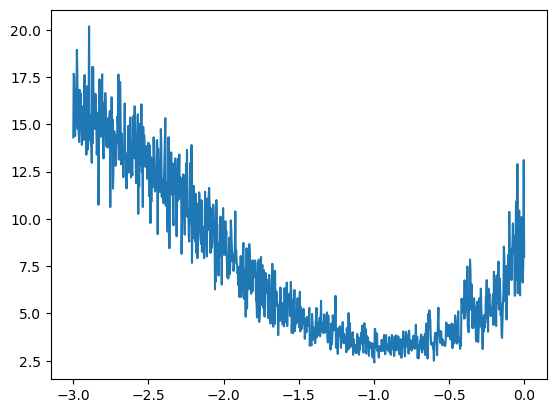

In [101]:
plt.plot(lri, lossi)

In [74]:
emb = C[X] # (32, 3, 2) as we are using trigrams, so 3 characters to predict the next character
h = torch.tanh(emb.view(-1, 6) @ W1 + b1 ) #(B x 100) First layer of non-linearity
logits = h @ W2 + b2 # Matrix calculations becore softmax
loss = F.cross_entropy(logits, Y) # Cross entropy does softmax internally and solves it

loss.item()

2.4262356758117676

In [ ]:
# train 80%, validation 10%, test 10%